# Import libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, MinMaxScaler,RobustScaler,MaxAbsScaler
from sklearn.compose import ColumnTransformer
from  sklearn.pipeline  import  Pipeline
from  sklearn  import  set_config
set_config(display='diagram')

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Custom functions

In [59]:
def dataset_parameters(df,target):
    df_features = df.drop([target], axis=1)
    data_type_numerical = ['int64', 'float64']
    data_type_object = ['object', 'bool', 'category']
    data_type_date = ['datetime64']
    categorical_features  = list(filter(lambda x: df_features[x].dtype in data_type_object, df_features.columns))
    numerical_features = list(filter(lambda x: df_features[x].dtype in data_type_numerical, df_features.columns))
    date_features = list(filter(lambda x: df_features[x].dtype in data_type_date, df_features.columns))
    all_features  = numerical_features  + categorical_features + date_features 
    return categorical_features, numerical_features, date_features, all_features,target 

In [60]:
def accuracy_performance(model, X, y):
    accuracy = round(model.score(X,y),3)
    return pd.DataFrame({'pipeline':[str(model)], 'accuracy':[accuracy]})

In [61]:
def classification_analysis(df):
    df['pipeline'] = df['pipeline'].apply(lambda x: x.split('(')[0])
    
    fig = plt.figure(figsize=(6, 4))
    sns.barplot(x='pipeline', y='accuracy', data=df)
    plt.ylim(0, 1)
    plt.xlabel('')
    plt.ylabel('accuracy', fontsize=10)
    plt.xticks(rotation=60, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', linewidth=0.8)

    plt.show()
    return df

In [62]:
def classificator_performance(model, X_test, y_test, target_names):
    y_pred = model.predict(X_test)
    return print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0)) 

In [63]:
def classificator_analysis(model, X_test, y_test, labels_name):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    labels = list(labels_name.values())
    swapped_dict = {v: k for k, v in labels_name.items()}
    y_test = y_test.map(swapped_dict)
    y_pred = pd.Series(y_pred).map(swapped_dict)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, cmap='Blues', annot=True, xticklabels=labels, yticklabels=labels, ax=axs[0])
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')

    # Plot ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(model.classes_.shape[0]):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        sns.lineplot(x=fpr[i], y=tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(labels_name[i], roc_auc[i]), linewidth=1.5, ax=axs[1])
    
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].legend(loc="lower right")

    # Plot Precision-Recall curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(model.classes_.shape[0]):
        precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred_proba[:, i])
        average_precision[i] = average_precision_score(y_test == i, y_pred_proba[:, i])
        sns.lineplot(x=recall[i], y=precision[i], label='Precision-recall curve (class {0}) (AP = {1:0.2f})'.format(labels_name[i], average_precision[i]), linewidth=1.5, ax=axs[2])
    
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('Recall')
    axs[2].set_ylabel('Precision')
    axs[2].legend(loc="lower left")

    return plt.show()

# Loading data

In [64]:
with open('penguins_species_classes.pkl', 'rb') as f:
    target_classes = pickle.load(f)

In [65]:
target_classes

{0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}

In [66]:
with open('penguins_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [67]:
df

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species
0,Torgersen,39.1,18.7,181.0,3750.0,MALE,Adelie
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,Adelie
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,Adelie
3,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,Adelie
4,Torgersen,39.3,20.6,190.0,3650.0,MALE,Adelie
...,...,...,...,...,...,...,...
328,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,Gentoo
329,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,Gentoo
330,Biscoe,50.4,15.7,222.0,5750.0,MALE,Gentoo
331,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,Gentoo


In [68]:
categorical_features, numerical_features, date_features, all_features, target = dataset_parameters(df,'species')

In [69]:
X = df[all_features]

In [70]:
y = df[target]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13) 

# Setup pipeline

In [72]:
categorical_transformer = Pipeline(steps=[
    ('one' , OneHotEncoder())
])

In [73]:
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('normalize', Normalizer())
])

In [74]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [75]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', AdaBoostClassifier())
])

In [76]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['island', 'sex'])])),
                ('model', AdaBoostClassifier())])

# Setup and run grid search

In [77]:
params_space = {
    'preprocessor__num__scale': [StandardScaler(), MaxAbsScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    'preprocessor__num__normalize': [Normalizer(), 'passthrough'],
    'model__base_estimator' : [LogisticRegression(), RandomForestClassifier(), 'passthrough']
}

In [78]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

In [79]:
grid = GridSearchCV(pipeline, param_grid=params_space, cv=25, n_jobs=-1, scoring=scoring, refit="f1", verbose=1)

In [80]:
grid.fit(X_train,  y_train)

Fitting 25 folds for each of 30 candidates, totalling 750 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

GridSearchCV(cv=25,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler()),
                                                                                         ('normalize',
                                                                                          Normalizer())]),
                                                                         ['culmen_length_mm',
                                                                          'culmen_depth_mm',
                                                                          'flipper_length_mm',
                                                                          'body_mass_g']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('one',
                                                                                          OneHotEncoder())]),
                                                                         ['island',
                                                                          'sex'])])),
                                       ('model', AdaBoostClassifier())]),
             n...
             param_grid={'model__base_estimator': [LogisticRegression(),
                                                   RandomForestClassifier(),
                                                   'passthrough'],
                         'preprocessor__num__normalize': [Normalizer(),
                                                          'passthrough'],
                         'preprocessor__num__scale': [StandardScaler(),
                                                      MaxAbsScaler(),
                                                      MinMaxScaler(),
                                                      RobustScaler(),
                                                      'passthrough']},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro',
                      'recall': 'recall_macro'},
             verbose=1)

In [81]:
grid.best_score_

1.0

In [82]:
grid.best_params_

{'model__base_estimator': LogisticRegression(),
 'preprocessor__num__normalize': 'passthrough',
 'preprocessor__num__scale': RobustScaler()}

In [83]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   RobustScaler()),
                                                                  ('normalize',
                                                                   'passthrough')]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['island', 'sex'])])),
                ('model',
                 AdaBoostClassifier(base_estimator=LogisticRegression()))])

In [84]:
best_params = pd.DataFrame(grid.cv_results_)

In [85]:
best_params [['mean_test_accuracy', 'rank_test_accuracy',
     'mean_test_precision','rank_test_precision',
     'mean_test_recall','rank_test_recall',
     'mean_test_f1', 'rank_test_f1']].sort_values(by='rank_test_accuracy', ascending=True).head(10)

,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall,mean_test_f1,rank_test_f1
8,1.000000,1,1.000000,1,1.000000,1,1.000000,1
12,0.996000,2,0.997333,2,0.993333,3,0.994074,3
2,0.996000,2,0.995556,6,0.997333,2,0.995852,2
11,0.996000,2,0.997333,2,0.993333,3,0.994074,3
0,0.995556,5,0.997333,2,0.993333,5,0.994074,3
5,0.995556,5,0.997333,2,0.993333,5,0.994074,3
9,0.992000,7,0.994000,8,0.990667,7,0.990688,7
7,0.991556,8,0.994667,7,0.988889,8,0.989926,8
3,0.987556,9,0.992000,9,0.984444,10,0.985778,9
10,0.987556,9,0.990222,10,0.985556,9,0.985354,10


In [86]:
best_params['params'][1]

{'model__base_estimator': LogisticRegression(),
 'preprocessor__num__normalize': Normalizer(),
 'preprocessor__num__scale': MaxAbsScaler()}

# Base vs Best pipeline

In [87]:
categorical_transformer_base = Pipeline(steps=[
    ('one' , OneHotEncoder())
])

In [88]:
numerical_transformer_base = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('normalize', Normalizer())
])

In [89]:
preprocessor_base = ColumnTransformer(transformers=[
    ('num', numerical_transformer_base, numerical_features),
    ('cat', categorical_transformer_base, categorical_features)
])

In [90]:
pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('model', AdaBoostClassifier())
])

In [91]:
pipeline_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['island', 'sex'])])),
                ('model', AdaBoostClassifier())])

In [92]:
categorical_transformer_best = Pipeline(steps=[
    ('one' , OneHotEncoder())
])

In [93]:
numerical_transformer_best = Pipeline(steps=[
    ('scale', RobustScaler()),
])

In [94]:
preprocessor_best= ColumnTransformer(transformers=[
    ('num', numerical_transformer_best, numerical_features),
    ('cat', categorical_transformer_best, categorical_features)
])

In [95]:
pipeline_best = Pipeline(steps=[
    ('preprocessor', preprocessor_best),
    ('model', AdaBoostClassifier(base_estimator=LogisticRegression()))
])

In [96]:
pipeline_best.fit(X_train, y_train)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   RobustScaler())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['island', 'sex'])])),
                ('model',
                 AdaBoostClassifier(base_estimator=LogisticRegression()))])

In [97]:
pipeline_base_train = accuracy_performance(pipeline_base, X_train, y_train)
pipeline_base_test = accuracy_performance(pipeline_base, X_test, y_test)

In [98]:
pipeline_base_train.insert(1, 'data', 'train')
pipeline_base_train['pipeline'] = 'base'
pipeline_base_test.insert(1, 'data', 'test')
pipeline_base_test['pipeline'] = 'base'
results = pd.concat([pipeline_base_train, pipeline_base_test], ignore_index=True)

In [99]:
pipeline_best_train = accuracy_performance(pipeline_best, X_train, y_train)
pipeline_best_test = accuracy_performance(pipeline_best, X_test, y_test)

In [100]:
pipeline_best_train.insert(1, 'data', 'train')
pipeline_best_train['pipeline'] = 'best'
pipeline_best_test.insert(1, 'data', 'test')
pipeline_best_test['pipeline'] = 'best'
results = pd.concat([results,pipeline_best_train, pipeline_best_test], ignore_index=True)

### Base pipeline vs Best pipeline - Accuracy

In [101]:
results

,pipeline,data,accuracy
0,base,train,0.695
1,base,test,0.750
2,best,train,0.996
3,best,test,1.000


In [102]:
df_results = results[(results['data'] != 'train')]
df_results = df_results.sort_values(by='accuracy', ascending=False)
df_results = df_results.reset_index(drop=True)
df_results.index = df_results.index + 1

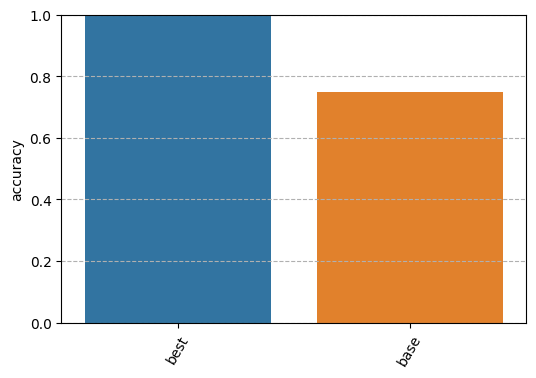

,pipeline,data,accuracy
1,best,test,1.00
2,base,test,0.75


In [103]:
classification_analysis(df_results)

### Base pipeline vs Best pipeline - Classificator performance for train dataset

In [104]:
classificator_performance(pipeline_base, X_train, y_train, target_classes.values())

              precision    recall  f1-score   support

      Adelie       0.58      1.00      0.73       103
   Chinstrap       0.00      0.00      0.00        54
      Gentoo       1.00      0.76      0.86        92

    accuracy                           0.69       249
   macro avg       0.53      0.59      0.53       249
weighted avg       0.61      0.69      0.62       249



In [105]:
classificator_performance(pipeline_best, X_train, y_train, target_classes.values())

              precision    recall  f1-score   support

      Adelie       1.00      0.99      1.00       103
   Chinstrap       0.98      1.00      0.99        54
      Gentoo       1.00      1.00      1.00        92

    accuracy                           1.00       249
   macro avg       0.99      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249



### Base pipeline vs Best pipeline - Classificator performance for test dataset

In [106]:
classificator_performance(pipeline_base, X_test, y_test, target_classes.values())

              precision    recall  f1-score   support

      Adelie       0.68      0.98      0.80        43
   Chinstrap       0.00      0.00      0.00        14
      Gentoo       0.95      0.78      0.86        27

    accuracy                           0.75        84
   macro avg       0.54      0.58      0.55        84
weighted avg       0.65      0.75      0.69        84



In [107]:
classificator_performance(pipeline_best, X_test, y_test, target_classes.values())

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        43
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        27

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



### Base pipeline vs Best pipeline - Confusion Matrix, ROC and Recall curve

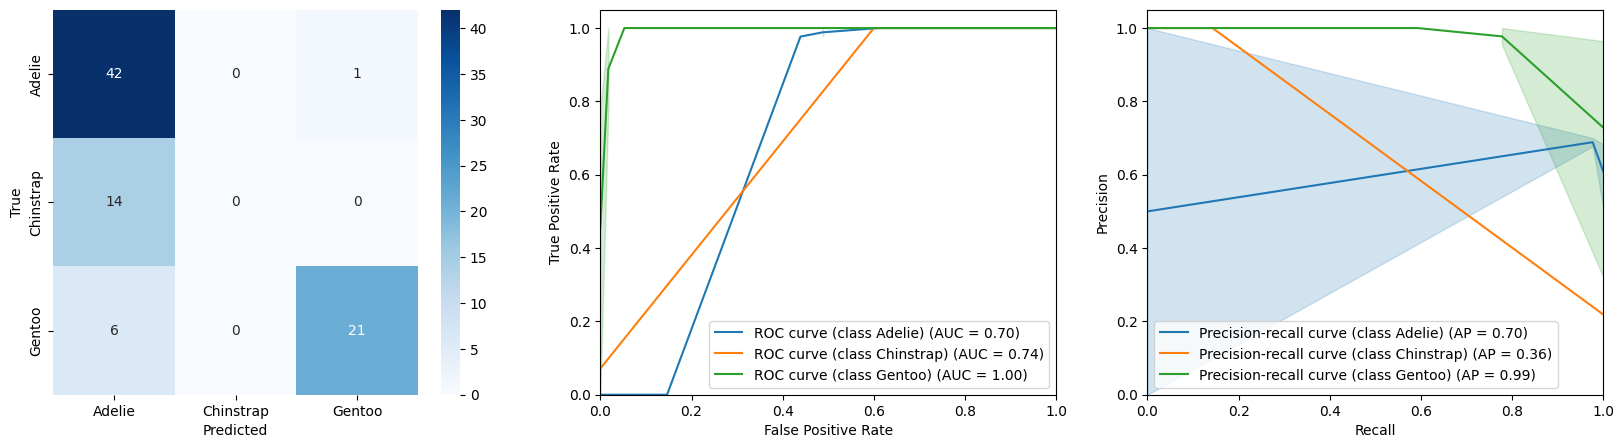

In [108]:
classificator_analysis(model=pipeline_base, X_test=X_test, y_test=y_test, labels_name=target_classes)

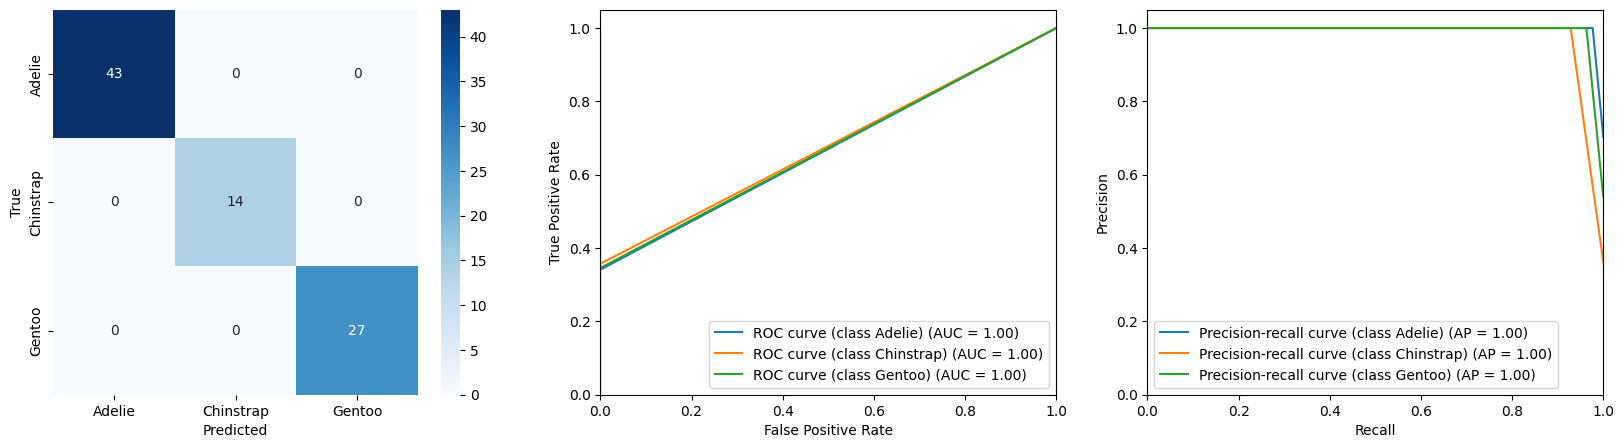

In [109]:
classificator_analysis(model=pipeline_best, X_test=X_test, y_test=y_test, labels_name=target_classes)